In [1]:
!pip install nonlinear_benchmarks # collection of system identification benchmarks


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## State-space identification with Jax

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import nonlinear_benchmarks
import optax
from tqdm import tqdm

In [3]:
key = jr.key(42)
keys = jr.split(key, 5)

### Load and visualize some data

In [4]:
train, test = nonlinear_benchmarks.Cascaded_Tanks(atleast_2d=True)
u_tr = train.u.astype(jnp.float32)
y_tr = train.y.astype(jnp.float32)
t_tr = train.sampling_time * jnp.arange(train.u.shape[0])
u_te = test.u.astype(jnp.float32)
y_te = test.y.astype(jnp.float32)
t_te = test.sampling_time * jnp.arange(test.u.shape[0])

In [5]:
u_tr.shape, y_tr.shape

((1024, 1), (1024, 1))

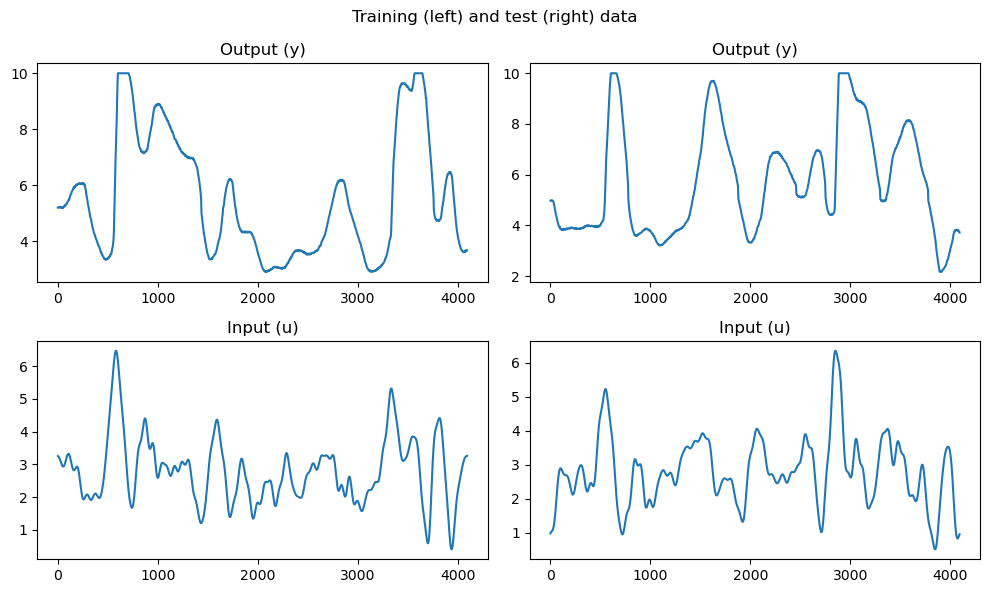

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
plt.suptitle("Training (left) and test (right) data")

ax[0, 0].set_title("Output (y)")
ax[0, 0].plot(t_tr, y_tr)

ax[1, 0].set_title("Input (u)")
ax[1, 0].plot(t_tr, u_tr)

ax[0, 1].set_title("Output (y)")
ax[0, 1].plot(t_te, y_te)

ax[1, 1].set_title("Input (u)")
ax[1, 1].plot(t_te, u_te)
plt.tight_layout()

### Pre-processing

In [7]:
# Scale inputs and outputs for better training performance
# In production code, I'd use sklearn.preprocessing.StandardScaler or similar
# Here we implement standard scaling manually for educational purposes

u_mean = jnp.mean(u_tr)
u_std = jnp.std(u_tr)
u_tr_sc = (u_tr - u_mean) / u_std
u_te_sc = (u_te - u_mean) / u_std

y_mean = jnp.mean(y_tr)
y_std = jnp.std(y_tr)
y_tr_sc = (y_tr - y_mean) / y_std

In [8]:
# Same shapes as before...
u_tr_sc.shape, y_tr_sc.shape

((1024, 1), (1024, 1))

In [9]:
# ... but normalized to zero mean and unit variance
u_tr_sc.mean(), u_tr_sc.std()

(Array(-4.246831e-07, dtype=float32), Array(1., dtype=float32))

### Define optimization variables, model and loss

In [10]:
# Initialize all parameters and organize them in a dictionary
nu = 1; nx = 2; ny = 1; nh = 16

params = {
    "W1": jr.normal(keys[0], shape=(nh, nu + nx)),  # nu + nx inputs to the network
    "b1": jr.normal(keys[1], shape=(nh,)),
    "W2": jr.normal(keys[2], shape=(nx, nh)) * 1e-3,  # nx outputs from the network
    "b2": jr.normal(keys[3], shape=(nx,)) * 1e-3,
    
    "C": jr.normal(keys[4], shape=(ny, nx)),  # nx inputs and ny outputs
}

In [11]:
# Define state-update and output functions
def f(p, x, u):
    xu = jnp.concatenate([x, u])
    z = jnp.tanh(p["W1"] @ xu + p["b1"])
    x_new = x + p["W2"] @ z + p["b2"]
    return x_new

def g(p, x):
    y = p["C"] @ x
    return y

# Define simulation function
def sim(p, x, us):
    # x: (nx) initial state
    # us:(T, nu) input sequence
    y_sim = []
    for t in range(us.shape[0]):
        y_sim.append(g(p, x))
        x = f(p, x, us[t])

    # (T, ny) simulated output sequence
    y_sim = jnp.stack(y_sim)
    return y_sim 

In [12]:
# Equivalent implementation using jax.lax.scan (generally faster)
def sim_scan(p, x, us):
    def fg_func(x, u_t):
        return f(p, x, u_t), g(p, x)  # x_new, y

    xf, y_sim = jax.lax.scan(fg_func, x, us)
    return y_sim

In [ ]:
# check equivalence of sim and sim_scan...    
jnp.allclose(sim(params, jnp.zeros((nx,)), u_tr_sc), sim_scan(params, jnp.zeros((nx,)), u_tr_sc))

Array(True, dtype=bool)

In [14]:
opt_vars = {"params": params, "x0": jnp.zeros((nx,))}

In [15]:
def loss_fn(ov, ys, us):
    y_sim = sim_scan(ov["params"], ov["x0"], us)
    return jnp.mean((ys - y_sim) ** 2)

In [16]:
loss_fn(opt_vars, y_tr_sc, u_tr_sc)

Array(2.7124455, dtype=float32)

### Train model

In [17]:
# Setup optimizer
lr = 1e-3
iters = 2_000
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(opt_vars)
loss_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

# Training loop
LOSS = []
for iter in (pbar := tqdm(range(iters))):
    loss_val, grads = loss_grad_fn(opt_vars, y_tr_sc, u_tr_sc)
    updates, opt_state = optimizer.update(grads, opt_state)
    opt_vars = optax.apply_updates(opt_vars, updates)
    LOSS.append(loss_val)
    if iter % 100 == 0:
        pbar.set_postfix_str(f"Loss step {iter}: {loss_val}")

100%|██████████| 2000/2000 [00:05<00:00, 365.97it/s, Loss step 1900: 0.007123515475541353] 


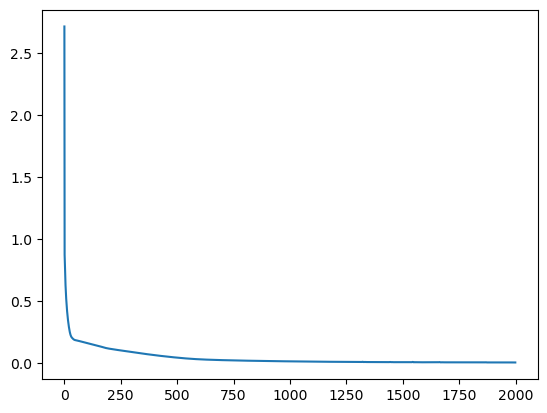

In [18]:
plt.figure()
plt.plot(LOSS)

In [19]:
y_te_sim = sim(opt_vars["params"], opt_vars["x0"], u_te_sc)
y_te_sim = y_te_sim * y_std + y_mean

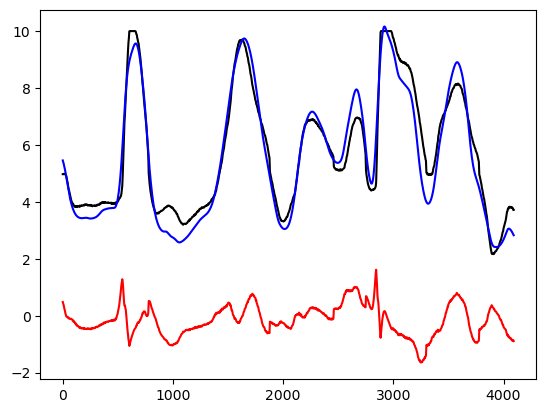

In [20]:
plt.figure()
plt.plot(t_te, y_te, "k")
plt.plot(t_te, y_te_sim, "b")
plt.plot(t_te, y_te_sim - y_te, "r")
plt.show()

In [21]:
rmse = jnp.sqrt(jnp.mean((y_te_sim - y_te) ** 2))
rmse # 0.36624

Array(0.55635107, dtype=float32)